# $4^{th}$ exercise

## Notebook setup

#### Used libraries

In [2]:
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt

#### Functions

In [24]:
#Plot shortcuts
def PlotSetup():
    plt.axes().set_facecolor(bg1)
    plt.grid(alpha=0.3)

def MultiplotSetup(fig,r,c,nplots=0):
    if nplots == 0 : nplots=r*c
    for i in range(nplots):
        plt.subplot(r,c,i+1)
        fig.axes[i].set_facecolor(bg1)
        plt.grid(alpha=0.3) 
    
def Legend():
    leg = plt.legend(facecolor=bg2)
    for text in leg.get_texts():
        text.set_color(el1)
        
def Errbar1Sigma(x,y,e):
    plt.vlines(x,y-e,y+e,color=er1,alpha=0.8, label="$1\sigma$")
    plt.plot(x,y,color=el1)
    
def Errbar2Sigma(x,y,e):
    plt.vlines(x,y-e,y+e,color=er1,alpha=0.8, label="$1\sigma$")
    plt.vlines(x,y-2*e,y+2*e,color=er2,alpha=0.4, label="$2\sigma$")
    plt.plot(x,y,color=el1)

#### Colors, just for fun

In [3]:
#background
bg1 = "#191724" 
bg2 = "#26233a" 
#elements
el1 = "#e0def4" 
el2 = "#f6c177" 
el3 = "#eb6f92" 
#errorbars
er1 = "#908caa"  
er2 = "#6e6a86"

#### Constants

In [48]:
sgm=0.34e-9
m=6.635181e-26
kb=1.38e-23
ekb=120
eps=ekb*kb

## 04.2 - Molecular dynamics in the microcanonical ensamble: Argon in the Lennard-Jones approximation

### Introductory notes
Microcanonical ensamble is a statistical ensamble in which the number of particles, the volume and the energy are kept constant, that means we have a motion bound to a constant-energy surface in the phase space. For this reason an algorithm that preserves energy can be used to simulate the motion of the microscopical components of a system in order to obtain thermodinamical quantities (note that, because of Lyapunov instability we can't use an algorithm that has limited precision to study the microscopical position and velocities of the particles). We are going to briefly discuss the algorithm used, the model and the evaluation of relevant quantities.

In our simulations we are going to use the Verlet algorithm, which is a two steps method that shows good long-term conservation energy (the reason of that can be elegantly found through geometric arguments considering the algorithm as a discrete map of the phase space in itself). Using $r^i=r(t_i)$ and $\delta t=t_{i+1}-t_i$ the verlet method is: 
\begin{equation}
r^{i+1}=2r^i-r^{i-1} + \frac{F(t_i)}{m}\delta t^2
\end{equation}
By knowing two successive positions we are always able to evaluate the next one. The main drawbacks are:
- Velocity does not appear in the scheme, so we have to use an approximate expression for the derivative of the position in order to obtain it, which reduces the precision of the algorithm
- The method is not self starting since it requires two positions.
A possible solution is, given the starting position of the particle, to evaluate some random velocities compatible with the input temperature and from those evaluate the previus configuration of the system.

Also, since we are interested in the bulk properties we are going to use periodic boundary conditions in order to avoid surface effects and to consider interaction only with particles (or their image through periodic boundary conditions) inside a cutoff radious.

We are going to simulate a sistem composed of Argon interacting through a Lennard-Jones potential, a simple model capturing the observed long-distance attraction and the rapid short-distance repulsion that is a fair approximation in the case of noble elements.
We have, for two particles at distance $r_{ij}$
\begin{equation}
V_{ij}=4\varepsilon\Biggl[ \biggl(\frac{\sigma}{r_{ij}}\biggr)^{12} - \biggl(\frac{\sigma}{r_{ij}}\biggr)^{6}\Biggr]
\end{equation}
where $\varepsilon,\sigma$ are two parameters. We are going to work in reduced units (i.e. by rescaling every quantity by the lenght factor $\sigma$, the energy factor $\varepsilon$ and the mass of the Argon) in order to have quantities of order $1$ and avoid over- or underflow.

About the quantities we are interested in, knowing the simulated positions and velocities we have direct access potential and kinetic energy. Using the equipartition of energy we can evaluate the temperature and by means of the virial theorem we have the pressure.


### Brief recap
**Goal:** Simulate a system $N=1.8$ Argon atoms in the Lennard-Jones approximation in the phases:
- Solid $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
- Liquid $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
- Gas $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

**Note:**  An important observation before starting: we are feeding our program with an fcc crystal whith cell-side lenght equal to 1 as a starting configuration, and providing as inputs temperature, density and number of particles. Before starting the simulation, we use the input density and number of particles to find to scale up the fcc cell, and apply periodic boundary condition to it. Clearly in the fluid phases, but also in the solid one, our system wont be a perfect crystal and this will lead to an increase of the potential energy in the first phases of the simulation. Since we are in the microcanonical ensamble (the total energy is fixed) the kinetic energy will decrease, resulting in a temperature drop. The same reasoning applies to the gas state but here the density is much lower: after scaling up the sistem we found that the particles are far from each other, so the system is far from lennard-jones minimum. As a result, in the first phases of the simulation we will have a lowering of the potential energy, resulting in an increase of the temperature. For these reason, we have to use an input temperature different from the target one and wait a reasonable number of steps to allow the system to reach equilibrium around the target temperature.

### Solid
#### Equilibration

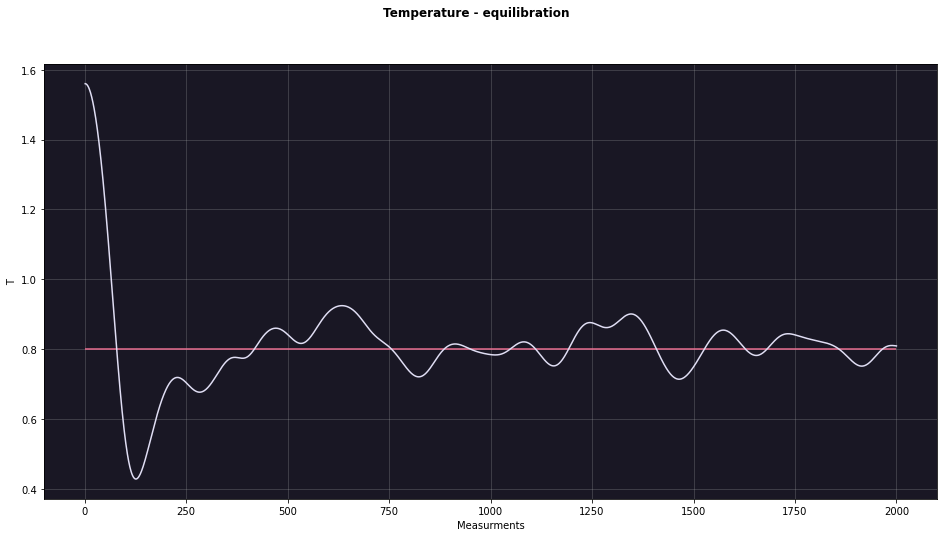

In [30]:
fig=plt.figure(figsize=(16, 8))
plt.axes().set_facecolor(bg1)
plt.grid(alpha=0.3)

plt.suptitle('Temperature - equilibration', weight='bold')
plt.xlabel('Measurments')
plt.ylabel('T')

state="solid"
x,y = np.loadtxt("store/"+state+"_equilibration.dat", usecols=(0,1),unpack=True)

plt.hlines(0.8, 0,2000,color=el3)
plt.errorbar(x,y,color=el1)

plt.show()

Here we observe the expected temperature drop. After almost 500 steps the system stabilizes around the desired target value of $0.8$. In order to get this value, we had to start the simulation at $T=1.56$

#### Simulation

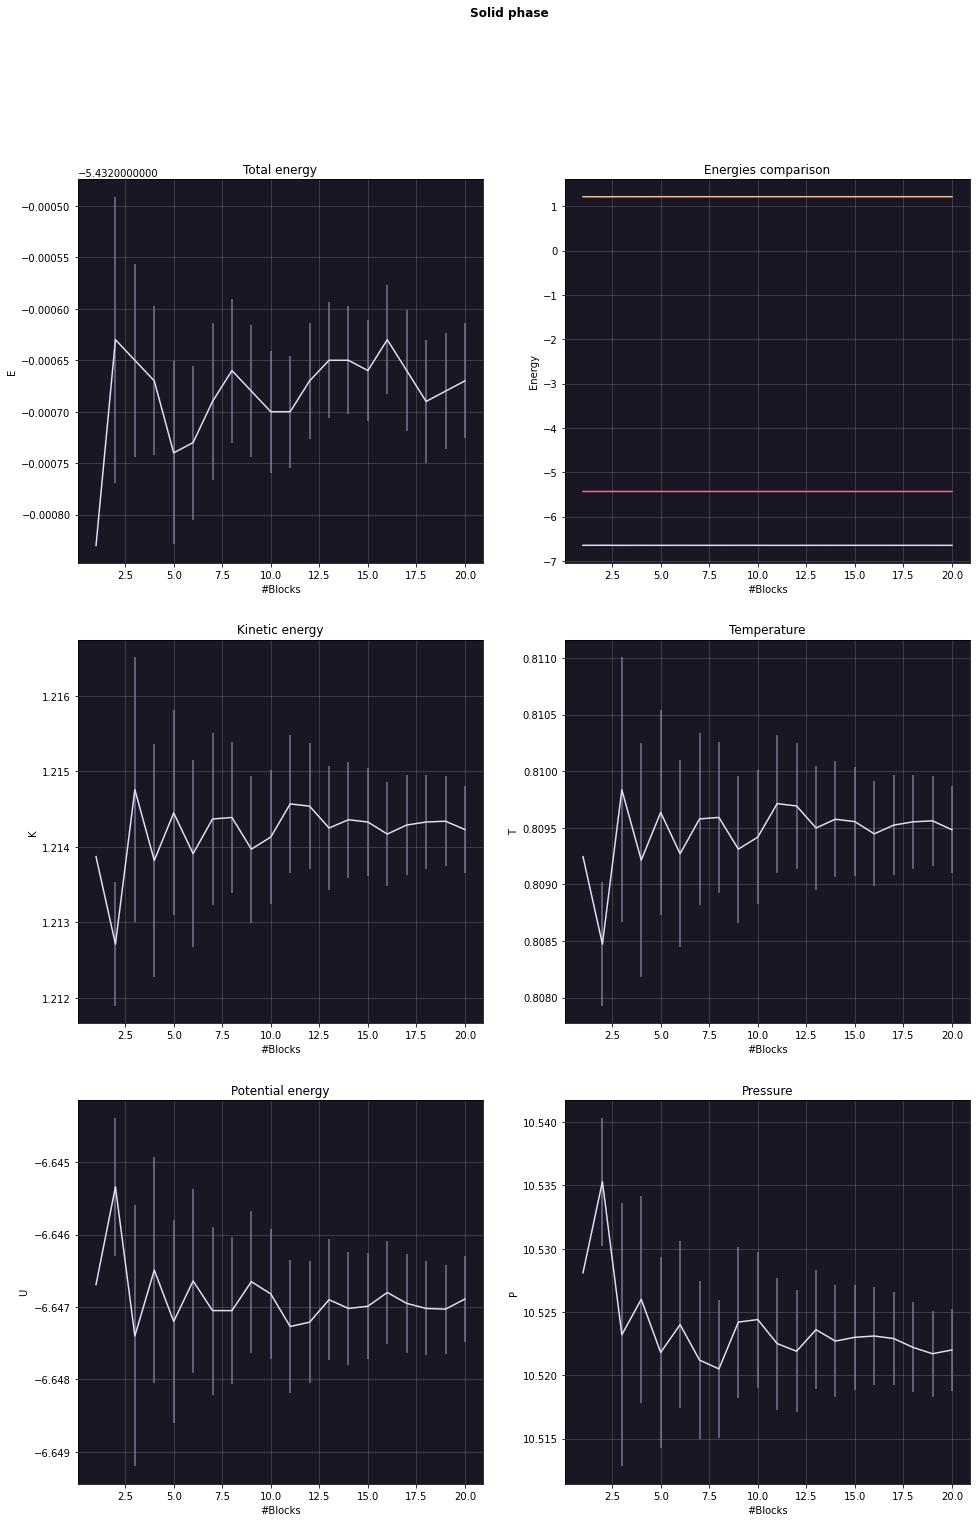

In [50]:
fig=plt.figure(figsize=(16, 24))
MultiplotSetup(fig,3,2)
plt.suptitle('Solid phase', weight='bold')

state="solid"

#Total energy
plt.subplot(321)
plt.title("Total energy")
plt.xlabel('#Blocks')
plt.ylabel('E')

x,y,e = np.loadtxt("out/"+state+"/output_etot.dat", usecols=(0,2,3),unpack=True)

Errbar1Sigma(x,y,e)

#Kinetic energy
plt.subplot(323)
plt.title("Kinetic energy")
plt.xlabel('#Blocks')
plt.ylabel('K')

x,y,e = np.loadtxt("out/"+state+"/output_ekin.dat", usecols=(0,2,3),unpack=True)

Errbar1Sigma(x,y,e)

#Potential energy
plt.subplot(325)
plt.title("Potential energy")
plt.xlabel('#Blocks')
plt.ylabel('U')

x,y,e = np.loadtxt("out/"+state+"/output_epot.dat", usecols=(0,2,3),unpack=True)

Errbar1Sigma(x,y,e)

#Energies comparison
plt.subplot(322)
plt.title("Energies comparison")
plt.xlabel('#Blocks')
plt.ylabel('Energy')

x,y_tot,e_tot = np.loadtxt("out/"+state+"/output_etot.dat", usecols=(0,2,3),unpack=True)
y_kin,e_kin = np.loadtxt("out/"+state+"/output_ekin.dat", usecols=(2,3),unpack=True)
y_pot,e_pot = np.loadtxt("out/"+state+"/output_epot.dat", usecols=(2,3),unpack=True)

plt.errorbar(x,y_tot,e_tot,c=el3,label="Total energy")
plt.errorbar(x,y_kin,e_kin,c=el2,label="Kinetic energy")
plt.errorbar(x,y_pot,e_pot,c=el1,label="Potential energy")

#Temperature 
plt.subplot(324)
plt.title("Temperature")
plt.xlabel('#Blocks')
plt.ylabel('T')

x,y,e = np.loadtxt("out/"+state+"/output_temp.dat", usecols=(0,2,3),unpack=True)

Errbar1Sigma(x,y,e)

#Pressure 
plt.subplot(326)
plt.title("Pressure")
plt.xlabel('#Blocks')
plt.ylabel('P')

x,y,e = np.loadtxt("out/"+state+"/output_pres.dat", usecols=(0,2,3),unpack=True)

Errbar1Sigma(x,y,e)


plt.show()

### Liquid
#### Equilibration

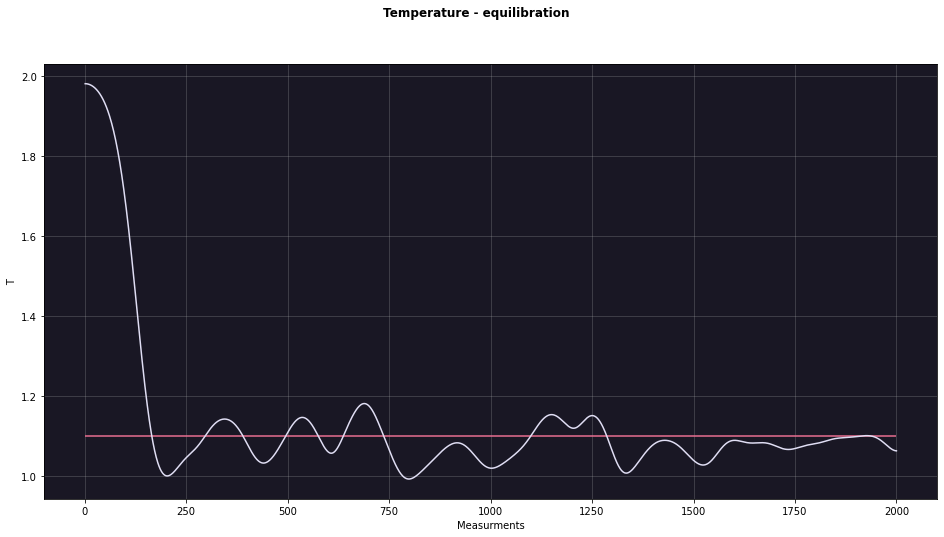

In [37]:
fig=plt.figure(figsize=(16, 8))

plt.axes().set_facecolor(bg1)
plt.grid(alpha=0.3)

plt.suptitle('Temperature - equilibration', weight='bold')
plt.xlabel('Measurments')
plt.ylabel('T')

state="liquid"
x,y = np.loadtxt("store/"+state+"_equilibration.dat", usecols=(0,1),unpack=True)

plt.hlines(1.1, 0,2000,color=el3)
plt.errorbar(x,y,color=el1)

plt.show()

As in the solid case, after 500 steps we have already reached the target value of $1.1$. The starting value was $T=1.98$

#### Simulation

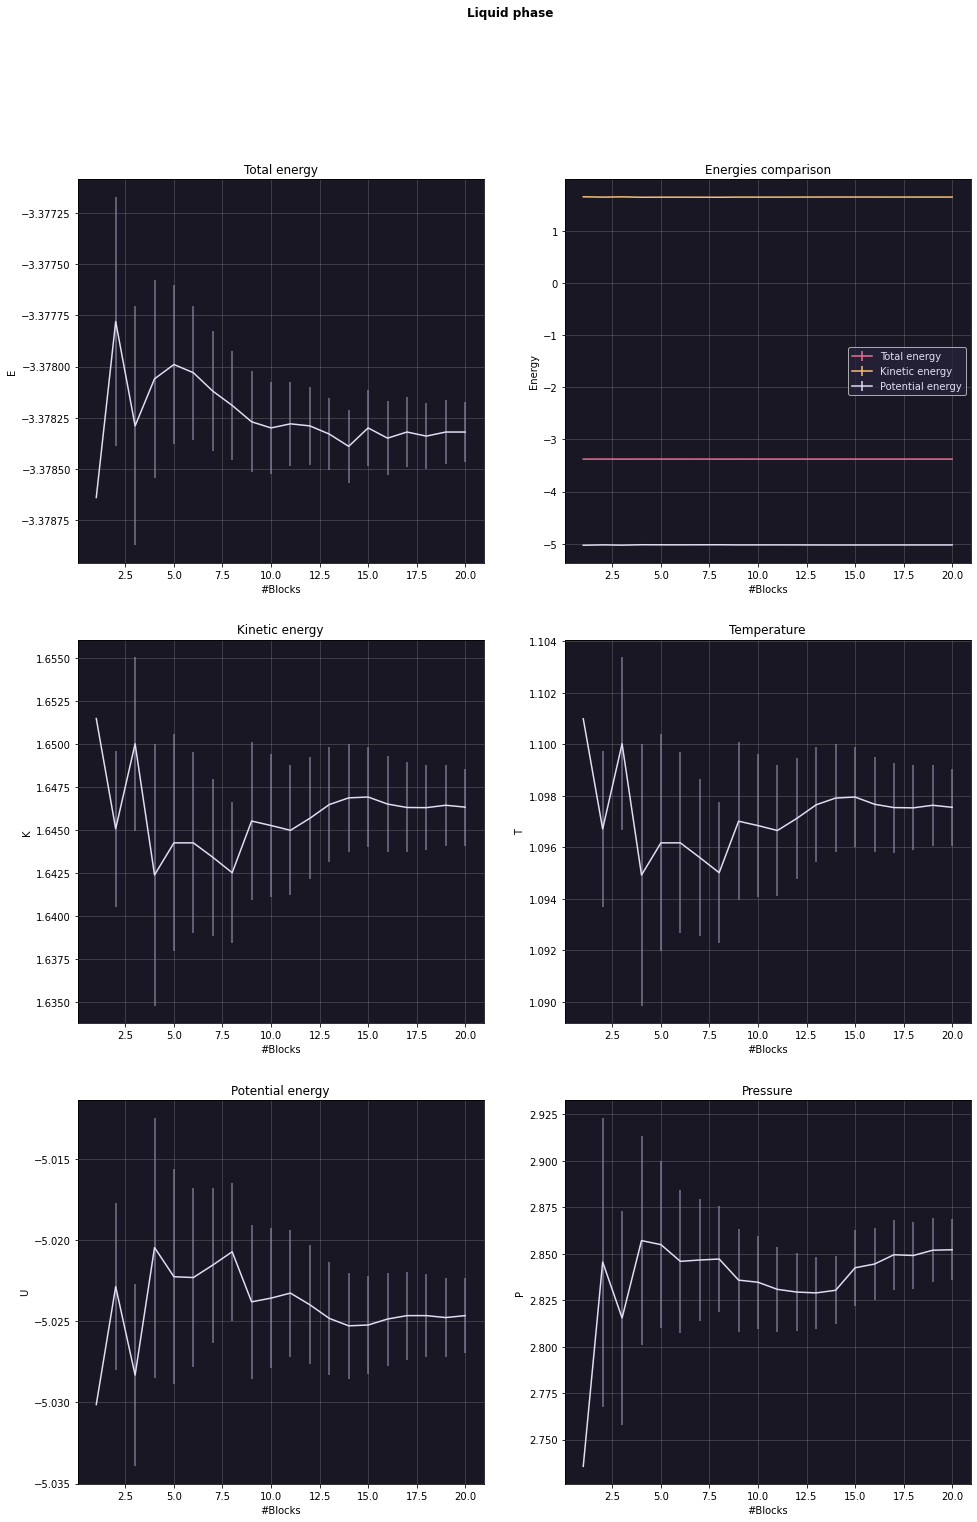

In [46]:
fig=plt.figure(figsize=(16, 24))
MultiplotSetup(fig,3,2)
plt.suptitle('Liquid phase', weight='bold')

state="liquid"

#Total energy
plt.subplot(321)
plt.title("Total energy")
plt.xlabel('#Blocks')
plt.ylabel('E')

x,y,e = np.loadtxt("out/"+state+"/output_etot.dat", usecols=(0,2,3),unpack=True)

Errbar1Sigma(x,y,e)

#Kinetic energy
plt.subplot(323)
plt.title("Kinetic energy")
plt.xlabel('#Blocks')
plt.ylabel('K')

x,y,e = np.loadtxt("out/"+state+"/output_ekin.dat", usecols=(0,2,3),unpack=True)

Errbar1Sigma(x,y,e)

#Potential energy
plt.subplot(325)
plt.title("Potential energy")
plt.xlabel('#Blocks')
plt.ylabel('U')

x,y,e = np.loadtxt("out/"+state+"/output_epot.dat", usecols=(0,2,3),unpack=True)

Errbar1Sigma(x,y,e)

#Energies comparison
plt.subplot(322)
plt.title("Energies comparison")
plt.xlabel('#Blocks')
plt.ylabel('Energy')

x,y_tot,e_tot = np.loadtxt("out/"+state+"/output_etot.dat", usecols=(0,2,3),unpack=True)
y_kin,e_kin = np.loadtxt("out/"+state+"/output_ekin.dat", usecols=(2,3),unpack=True)
y_pot,e_pot = np.loadtxt("out/"+state+"/output_epot.dat", usecols=(2,3),unpack=True)

plt.errorbar(x,y_tot,e_tot,c=el3,label="Total energy")
plt.errorbar(x,y_kin,e_kin,c=el2,label="Kinetic energy")
plt.errorbar(x,y_pot,e_pot,c=el1,label="Potential energy")

Legend()

#Temperature 
plt.subplot(324)
plt.title("Temperature")
plt.xlabel('#Blocks')
plt.ylabel('T')

x,y,e = np.loadtxt("out/"+state+"/output_temp.dat", usecols=(0,2,3),unpack=True)

Errbar1Sigma(x,y,e)

#Pressure 
plt.subplot(326)
plt.title("Pressure")
plt.xlabel('#Blocks')
plt.ylabel('P')

x,y,e = np.loadtxt("out/"+state+"/output_pres.dat", usecols=(0,2,3),unpack=True)

Errbar1Sigma(x,y,e)


plt.show()

### Gas
#### Equilibration

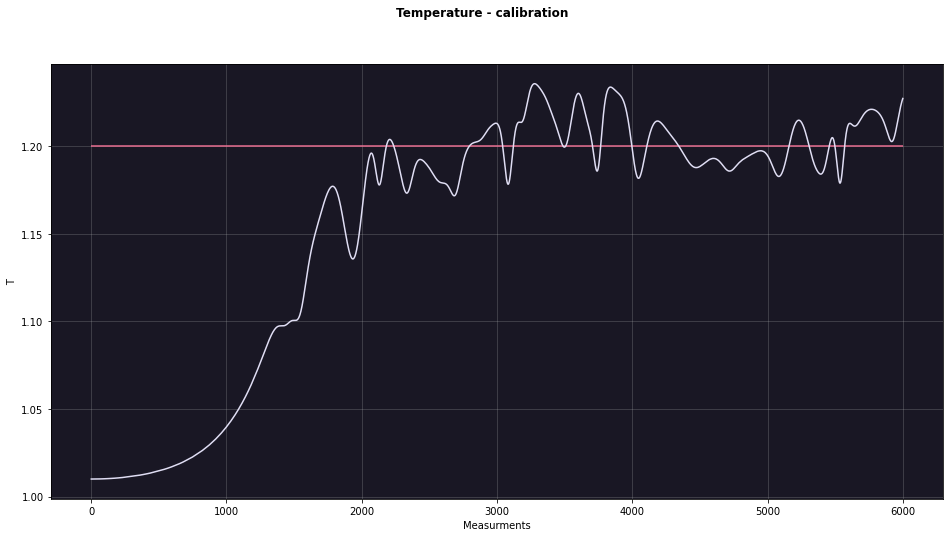

In [17]:
fig=plt.figure(figsize=(16, 8))

plt.axes().set_facecolor(bg1)
plt.grid(alpha=0.3)

plt.suptitle('Temperature - calibration', weight='bold')
plt.xlabel('Measurments')
plt.ylabel('T')

state="gas"
x,y = np.loadtxt("store/"+state+"_equilibration.dat", usecols=(0,1),unpack=True)

plt.hlines(1.2, 0,6000,color=el3)
plt.errorbar(x,y,color=el1)

plt.show()

In this case the equilibration is much longer, since we start far out of equilibrium. To reach the target value we had to start at $T=1.01$

#### Simulation

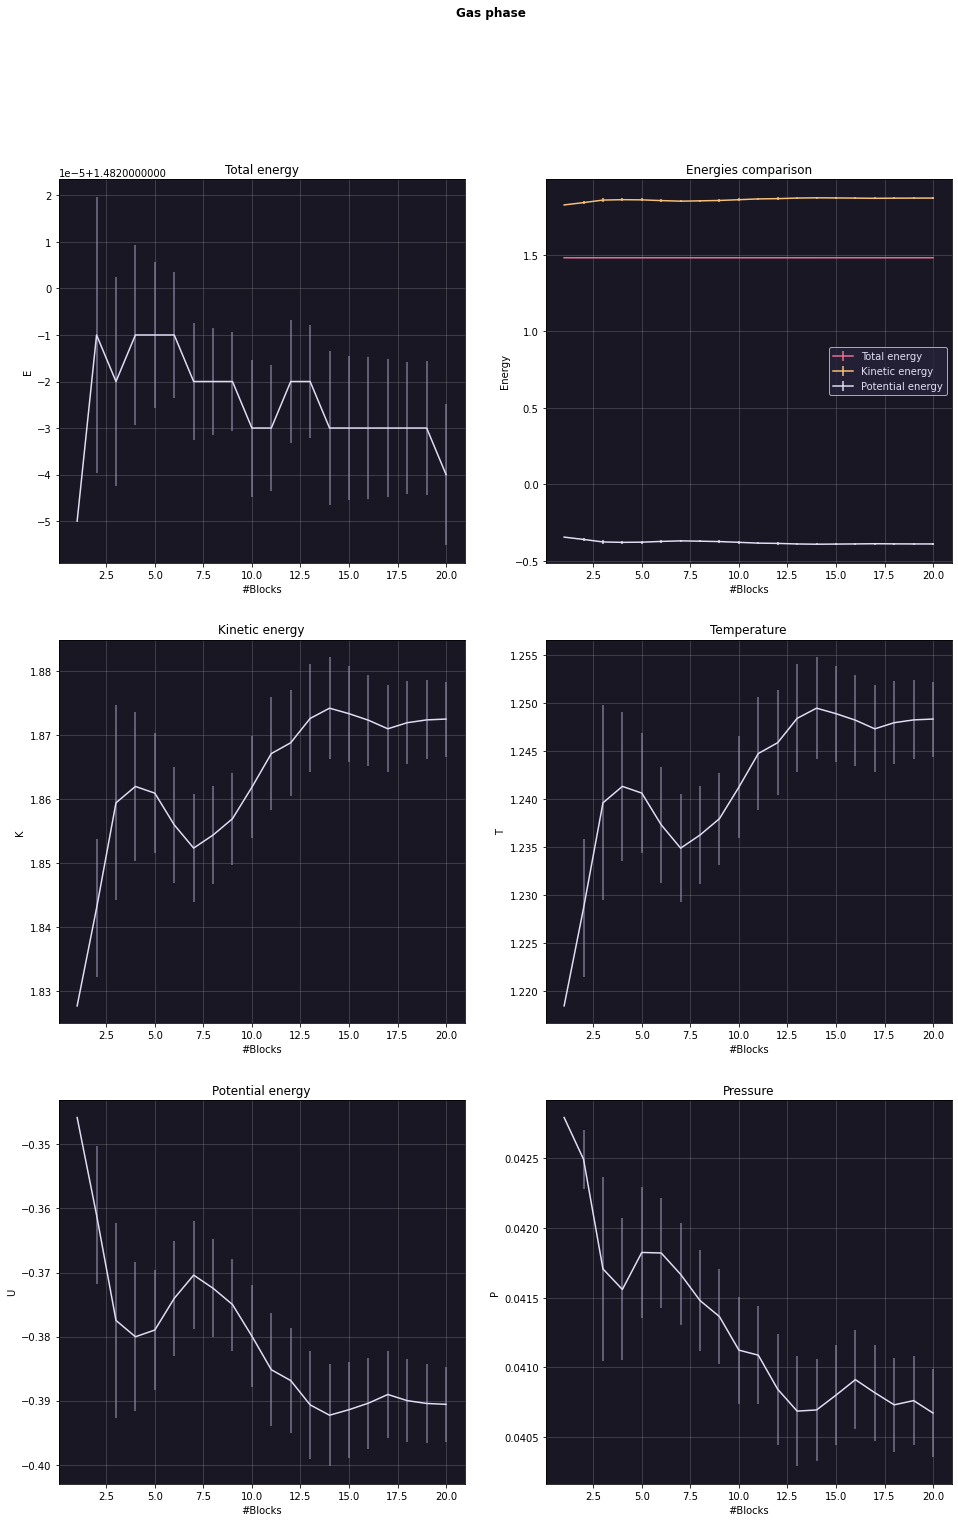

In [47]:
fig=plt.figure(figsize=(16, 24))
MultiplotSetup(fig,3,2)
plt.suptitle('Gas phase', weight='bold')

state="gas"

#Total energy
plt.subplot(321)
plt.title("Total energy")
plt.xlabel('#Blocks')
plt.ylabel('E')

x,y,e = np.loadtxt("out/"+state+"/output_etot.dat", usecols=(0,2,3),unpack=True)

Errbar1Sigma(x,y,e)

#Kinetic energy
plt.subplot(323)
plt.title("Kinetic energy")
plt.xlabel('#Blocks')
plt.ylabel('K')

x,y,e = np.loadtxt("out/"+state+"/output_ekin.dat", usecols=(0,2,3),unpack=True)

Errbar1Sigma(x,y,e)

#Potential energy
plt.subplot(325)
plt.title("Potential energy")
plt.xlabel('#Blocks')
plt.ylabel('U')

x,y,e = np.loadtxt("out/"+state+"/output_epot.dat", usecols=(0,2,3),unpack=True)

Errbar1Sigma(x,y,e)

#Energies comparison
plt.subplot(322)
plt.title("Energies comparison")
plt.xlabel('#Blocks')
plt.ylabel('Energy')

x,y_tot,e_tot = np.loadtxt("out/"+state+"/output_etot.dat", usecols=(0,2,3),unpack=True)
y_kin,e_kin = np.loadtxt("out/"+state+"/output_ekin.dat", usecols=(2,3),unpack=True)
y_pot,e_pot = np.loadtxt("out/"+state+"/output_epot.dat", usecols=(2,3),unpack=True)

plt.errorbar(x,y_tot,e_tot,c=el3,label="Total energy")
plt.errorbar(x,y_kin,e_kin,c=el2,label="Kinetic energy")
plt.errorbar(x,y_pot,e_pot,c=el1,label="Potential energy")

Legend()

#Temperature 
plt.subplot(324)
plt.title("Temperature")
plt.xlabel('#Blocks')
plt.ylabel('T')

x,y,e = np.loadtxt("out/"+state+"/output_temp.dat", usecols=(0,2,3),unpack=True)

Errbar1Sigma(x,y,e)

#Pressure 
plt.subplot(326)
plt.title("Pressure")
plt.xlabel('#Blocks')
plt.ylabel('P')

x,y,e = np.loadtxt("out/"+state+"/output_pres.dat", usecols=(0,2,3),unpack=True)

Errbar1Sigma(x,y,e)


plt.show()